# Setup

## Imports and Configuration

In [1]:
%load_ext autoreload
%autoreload 2

import os
import re
import json
from datetime import datetime
import functools
import matplotlib.pyplot as plt
import seaborn as sb
from anndata import AnnData
import scanpy as sc
import pandas as pd
import numpy as np
import corescpy as cr

pd.options.display.max_columns = 100
pd.options.display.max_rows = 200
sc.settings.set_figure_params(dpi=100, frameon=False, figsize=(20, 20))

palette = "tab20"


def construct_file(sample, slide, date=None, timestamp=None,
                   panel_id="TUQ97N", prefix="output-XETG00189",
                   project_owner="EA", run="CHO-001", directory=None):
    """Construct file path from information."""
    if isinstance(sample, str):
        sample = [sample]
    if "outputs" not in directory and os.path.exists(
            os.path.join(directory, "outputs")):
        directory = os.path.join(directory, "outputs")
    print(directory)
    panel_id, prefix, project_owner, slide, date, timestamp = [
        [x] * len(sample) if isinstance(x, str) else list(x) if x else x
        for x in [panel_id, prefix, project_owner, slide, date, timestamp]]
    run = [run] * len(sample) if isinstance(run, (str, int, float)) else run
    block = ["-".join(i) for i in zip(sample, panel_id, project_owner)]
    fff = [f"{prefix[i]}__{slide[i]}__{block[i]}" for i in range(len(sample))]
    if date is None or timestamp is None:
        for i, x in enumerate(fff):  # iterate current file stems
            ddd = os.path.join(directory, panel_id[i], run[i])
            print(ddd)
            matches = sum([x in d for d in os.listdir(ddd)])
            if  matches != 1:
                raise ValueError(f"{x} found in 0 or multiple file paths",
                                 f"\n\n{os.listdir(ddd)}")
            fff[i] = os.path.join(ddd, np.array(os.listdir(ddd))[np.where([
                x in d for d in os.listdir(ddd)])[0][0]])  # find match
    else:
        fff = [os.path.join(directory, panel_id[i], run[i],
                            f"{x}__{date[i]}__{timestamp[i]}")
               for i, x in enumerate(fff)]
    return fff

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

## Options

In [2]:
# Column Names
col_sample_id_original = "Sample ID"
col_sample_id = "Sample"
col_subject = "Patient"
col_batch = "Slide"
col_path = "file_path"
# col_date_time, col_date = "Date Sectioned", "Date"
col_date_time, col_date = None, None
col_inflamed, col_stricture = "Inflamed", "Stricture"
col_condition = "Condition"
meta_rn = {"Name": col_subject, "Slide ID": col_batch,
           "Inflammation Status": col_inflamed}

# Directories & Metadata
# Replace manually or mirror my file/directory tree in your home
include_stricture = True
run = "CHO-001"
samples = ["50452A", "50452B", "50452C"]
# samples = ["50452A", "50452B"]
# samples = ["50452A", "50452B", "50452C", "50564A4", "50618B5"]
# run = ["CHO-001"] * 3 + ["CHO-002"] * 3
panel_id = "TUQ97N"
prefix = "output-XETG00189"
project_owner = "EA"
ddu = os.path.expanduser("~")
ddl = "/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library"
ddd = os.path.join(ddl, "outputs", panel_id)
panel = os.path.join(ddu, "projects/senescence/ProposedGenePanel.xlsx")
file_ann = os.path.join(ddu, "corescpy/examples/annotation_guide.xlsx")

# Input/Output Options
reload = True
out_dir = os.path.join(ddd, "nebraska")  # set to None to avoid saving
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

# Computing Resources
gpu = False
sc.settings.n_jobs = 4
sc.settings.max_memory = 150

# Read Metadata & Other Information
annot_df = pd.read_excel(file_ann)
metadata = pd.read_excel(os.path.join(ddl, "Xenium_Samples_02092024.xlsx"),
                         dtype={"Slide ID": str})
metadata = metadata.rename(meta_rn, axis=1)
if samples not in ["all", None]:  # subset by sample ID?
    metadata = metadata.set_index(col_sample_id_original).loc[
        samples].reset_index()

# Processing & Clustering Options
resolution = 0.5
min_dist = 1
n_comps = 20
# col_qscore = ?
# custom_thresholds = {col_qscore: [, None]}
custom_thresholds = None
genes_subset = list(annot_df.iloc[:, 0])
kws_pp = dict(cell_filter_pmt=None, cell_filter_ncounts=[50, None],
              cell_filter_ngene=[30, None], gene_filter_ncell=[3, None],
              gene_filter_ncounts=[3, None],
              custom_thresholds=custom_thresholds,
              kws_scale=dict(max_value=10, zero_center=True))
kws_umap = dict(min_dist=min_dist, method="rapids") if gpu is True else dict(
    min_dist=min_dist)
kws_cluster = dict(use_gpu=gpu, kws_umap=kws_umap, kws_neighbors=None,
                   use_highly_variable=False, n_comps=n_comps,
                   genes_subset=genes_subset, resolution=resolution)
# kws_subcluster = dict(use_gpu=gpu, kws_umap=dict(min_dist=0.3),
#                       kws_neighbors=None, use_highly_variable=False,
#                       n_comps=n_comps, genes_subset=genes_subset,
#                       method_cluster="leiden", resolution=0.5)
kws_subcluster = dict(method_cluster="leiden", resolution=0.5)

# Revise Metadata & Construct Variables from Options
if col_stricture not in metadata.columns:
    metadata.loc[:, col_stricture] = metadata["Sample Location"].apply(
        lambda x: "Stricture" if "stricture" in x.lower() else "None")
metadata.loc[:, col_condition] = metadata.apply(
    lambda x: "Stricture" if "stricture" in x[col_stricture].lower() else x[
        col_inflamed].capitalize() , axis=1)
if col_date_time:
    metadata.loc[:, col_date] = metadata[col_date_time].apply(
        lambda x: datetime.strftime(x, "%Y%m%d"))
    dates = list(metadata[col_date])
else:
    dates = None
metadata.loc[:, col_sample_id] = metadata.apply(
    lambda x: f"{x[col_condition]}-{x[col_sample_id_original]}" , axis=1)
metadata = metadata.set_index(col_sample_id)
metadata.loc[:, col_path] = construct_file(
    list(metadata[col_sample_id_original]), list(metadata[col_batch]),
    dates, panel_id=panel_id, prefix=prefix,
    project_owner=project_owner, run=run, directory=ddl)
col_cell_type = "Annotation"
file_path_dict = dict(zip(metadata.index.values, metadata["file_path"]))
kws_init = dict(col_batch=col_batch, col_subject=col_subject,
                col_sample_id=col_sample_id, col_cell_type=col_cell_type)

# Annotation File
col_assignment = "Bin"
assign = pd.read_excel(file_ann, index_col=0).dropna(subset=col_assignment)
sources = assign[col_assignment].unique()
rename = dict(zip(sources, [" ".join([i.capitalize() if i and i[
    0] != "(" and not i.isupper() and i not in [
        "IgG", "IgA"] else i for i in x.split(" ")]) if len(x.split(
            " ")) > 1 else x for x in [re.sub("glia", "Glia", re.sub(
                "_", " ", j)) for j in sources]]))
assign.loc[:, col_assignment] = assign[col_assignment].replace(rename)
assign = assign.rename_axis("Gene")
marker_genes_dict = dict(assign.reset_index().groupby(col_assignment).apply(
    lambda x: list(pd.unique(x.Gene))))  # to marker dictionary

# Subset if Desired
if include_stricture is False:
    metadata = metadata[metadata.Stricture != "Stricture"]
metadata

# Genes
# genes = ["CDKN1A", "CDKN2A", "TP53", "PLAUR", "PTGER4", "FTL", "IL6ST"]
# cell_types = ["ILC3", "LTi-like NCR+ ILC3", "LTi-like NCR- ILC3",
#               "ILCP", "Macrophages", "Stem cells"]
# palette = ["r", "tab:pink", "m", "b", "tab:brown", "cyan"]
# High in inf. vs. un
# OSM
# IL13
# IL1B
# IL6
# TNF
# S100A8
# S100A9
# ------------------------------
# High in stricture vs inf/un
# PDGFRA
# IL6ST
# PTPN1
# IFNG

/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs
/mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/CHO-001


Sample ID  Patient     Status          Project  \
Sample                                                             
Uninflamed-50452A    50452A    50452  Available  scRNA & Spatial   

                  Sample Location    Inflamed    Slide  GRID ID  \
Sample                                                            
Uninflamed-50452A  Terminal Ileum  uninflamed  0010700  1011335   

                  Procedure Date  Age     Sex   Race Hispanic  \
Sample                                                          
Uninflamed-50452A     2023-12-04   69  female  white       NO   

                         Diagnosis            Project.1  Procedure  \
Sample                                                               
Uninflamed-50452A  Crohn's Disease  Helmsley-Senescence  Resection   

                  Disease Status  Date Collected      Date Sectioned  \
Sample                                                                 
Uninflamed-50452A         Active             NaN 2024-01-22 15:25:38   

                  Date of Hybridization Storage in 4C     Created By  \
Sample                                                                 
Uninflamed-50452A   2024-01-23 15:25:58           YES  ksenija sabic   

                                  Created  Storage Status  Sample Location.1  \
Sample                                                                         
Uninflamed-50452A 2024-02-06 15:26:47.887  Not in storage                NaN   

                   Storage Row  Storage Col  Checked Out By Stricture  \
Sample                                                                  
Uninflamed-50452A          NaN          NaN             NaN      None   

                    Condition  \
Sample                          
Uninflamed-50452A  Uninflamed   

                                                           file_path  
Sample                                                                
Uninflamed-50452A  /mnt/cho_lab/disk2/elizabeth/data/shared-xeniu...

# Data

## Loading

In [3]:
%%time

# Load Spatial Data
suff = str(f"res{re.sub('[.]', 'pt', str(resolution))}_dist"
           f"{re.sub('[.]', 'pt', str(min_dist))}_npc{n_comps}")  # file end
selves, paths_he, file_mks, out_files = [], [], [], []
for x in metadata.index.values:
    self = cr.Spatial(metadata.loc[x][col_path], library_id=x, **kws_init)
    for i in metadata:  # add metadata for subject
        self.rna.obs.loc[:, i] = str(metadata.loc[x][i])  # add metadata
    selves += [self]
    paths_he += [os.path.join(metadata.loc[x][
        col_path], "aux_outputs/image_he.ome.tif")]  # H&E paths
        # out_files += [os.path.join(out_dir, f"{x}.zarr")]
    if out_dir is not None:
        out_files += [os.path.join(out_dir, f"{x}__{suff}.zarr")]
    file_mks += [os.path.join(out_dir, f"{x}__{suff}_markers.csv")]

# Reload Processed & Clustered Data (Optionally)
if reload is True:
    for i, s in enumerate(selves):
        mks = file_mks[i] if os.path.exists(file_mks[i]) else None
        s.update_from_h5ad(file=out_files[i], file_path_markers=mks)
        print(s.adata)



<<< INITIALIZING SPATIAL CLASS OBJECT >>>



<<< INITIALIZING OMICS CLASS OBJECT >>>

Unused keyword arguments: {'library_id': 'Uninflamed-50452A', 'visium': False}.




col_gene_symbols="gene_symbols"
col_cell_type="Annotation"
col_sample_id="Sample"
col_batch="Slide"
col_subject="Patient"
col_condition=None
col_num_umis=None



key_control=None
key_treatment=None
INFO     reading                                                                                                   
         /mnt/cho_lab/disk2/elizabeth/data/shared-xenium-library/outputs/TUQ97N/CHO-001/output-XETG00189__0010700__
         50452A-TUQ97N-EA__20240126__205019/cell_feature_matrix.h5                                                 


dsfasfda AnnData object with n_obs × n_vars = 333825 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatialdata_attrs', 'spatial', 'original_ix'
    obsm: 'spatial'


Cell Counts: Initial


Observations: 333825



Gene Counts: Initial

Empty DataFrame
Columns: [index, gene_ids, feature_types, genome]
Index: []





 SpatialData object with:
├── Images
│     ├── 'morphology_focus': MultiscaleSpatialImage[cyx] (1, 57808, 45580), (1, 28904, 22790), (1, 14452, 11395), (1, 7226, 5697), (1, 3613, 2848)
│     └── 'morphology_mip': MultiscaleSpatialImage[cyx] (1, 57808, 45580), (1, 28904, 22790), (1, 14452, 11395), (1, 7226, 5697), (1, 3613, 2848)
├── Points
│     └── 'transcripts': DataFrame with shape: (<Delayed>, 10) (3D points)
├── Shapes
│     ├── 'cell_boundar

## Plot

In [ ]:
if reload is True:
    for i, s in enumerate(selves):
        s.plot_spatial(color="leiden")
        # s.plot_spatial(color=col_cell_type)

# Annotation & Sub-Clustering

In [ ]:
for s in selves:
    _ = s.cluster(**kws_cluster)
    _ = s.annotate_clusters(file_ann, col_cell_type="leiden",
                            col_annotation=col_cell_type,
                            col_assignment=col_assignment)  # annotate & write
    s.plot_spatial(color=col_cell_type)

In [ ]:
# cat_epi = ["BEST2+ Goblet Cell", "BEST4+ Epithelial", "EC Cells (NPW+)",
#            "EC Cells (TAC1+)", "Enterocyte", "Epithelial", "Goblet Cell",
#            "I Cells (CCK+)", "Paneth", "D Cells (SST+)",
#            "Stem Cells", "N Cells (NTS+)", "K Cells (GIP+)",
#            # "Colonocyte",
#            "L Cells (PYY+)", "Tuft", "Microfold Cell"]
# cat_epi = list(np.array()[np.where(["epithelial" in x.lower()
#                                     for x in marker_genes_dict])[0]])
# file_ann_epi = pd.concat([pd.Series(marker_genes_dict[x]) for x in cat_epi],
#                          keys=cat_epi, names=["Type"]).to_frame(
#                              "Gene").reset_index(0).set_index("Gene")
file_ann_epi = file_ann
# key_cell_type, col_ann = ["7"], "Subclustering_Epi"
key_cell_type, col_ann = None, "leiden_sub"
for s in selves:
    ann = s.subcluster(restrict_to=(col_cell_type, key_cell_type), copy=False,
                       key_added="leiden_sub", **kws_subcluster)
    s.annotate_clusters(kws_annotation={"model": file_ann_epi,
                                        "col_assignment": "Bin"},
                        col_annotation=[col_ann, col_cell_type])
    s.plot_spatial(color=col_ann)

In [ ]:
for s in selves:
    s.write(out_files[i])

# Workspace

In [5]:
# Impute GEX & Predict Labels from sc-RNA-seq Integration
i = 0
adata_sp = selves[i].adata.table.copy()
# adata_sc = sc.read(os.path.join("/mnt/cho_lab/disk2/elizabeth/data",
#                                 "2023-05-12_CombinedCD-v2_new.h5ad"))
# adata_sc = adata_sc[adata_sc.obs.Region == "Ileum"]
# sdata_new, sdata, adata_sc, ad_map, df_compare = cr.pp.integrate_spatial(
#     sdata, adata_sc, col_cell_type="ClusterAnnotation")
# adata_sc = sc.read("/mnt/cho_lab/disk2/elizabeth/data/elmentaite.h5ad",
#                    col_gene_symbols="feature_name")
# adata_sc = adata_sc[adata_sc.obs.tissue == "small intestine"]
# adata_sc.var = adata_sc.var.reset_index().set_index("feature_name")
col_annotation_t = "tangram_prediction"
out = cr.pp.integrate_spatial(
    adata_sp, adata_sc, col_cell_type="cell_type",
    # mode="cells",
    mode="clusters",
    key_added="rank_genes_groups_cell_type", markers=200,
    col_annotation=col_annotation_t,
    plot_density=False, plot_genes=None)
adata_sp_new, sdata, adata_sc_n, ad_map, df_compare, fig = out

# Write Predicted Annotation Mapping File for Xenium Explorer
adata_sp_new.obs.set_index("cell_id")[col_annotation_t].to_frame(
    "group").to_csv(os.path.splitext(
        out_files[i])[0] + f"_{col_annotation_t}.csv")

200 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
465 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
Allocate tensors for mapping.
Begin training with 200 genes and uniform density_prior in clusters mode...
Printing scores every 100 epochs.


Score: 0.330, KL reg: 0.054
Score: 0.573, KL reg: 0.003
Score: 0.580, KL reg: 0.003
Score: 0.582, KL reg: 0.003
Score: 0.583, KL reg: 0.003
Score: 0.583, KL reg: 0.003
Score: 0.583, KL reg: 0.003
Score: 0.584, KL reg: 0.003
Score: 0.584, KL reg: 0.003
Score: 0.584, KL reg: 0.003


Saving results..
spatial prediction dataframe is saved in `obsm` `tangram_ct_pred` of the spatial AnnData.


KeyError: 'tangram_ct_pred'

In [42]:
adata_sp_new = tg.project_genes(adata_map=ad_map, adata_sc=adata_sc)

ValueError: The two AnnDatas need to have same `obs` index.

In [41]:
sdata.obsm["tangram_ct_pred"]

stromal cell  mesodermal cell  enterocyte of colon  \
0       3.133152e-09     8.230007e-09         1.029421e-08   
1       5.299712e-06     6.225337e-06         2.497223e-06   
2       1.159862e-05     2.261884e-08         6.620805e-09   
3       9.542347e-06     3.287576e-08         7.404245e-07   
4       6.165138e-08     4.729897e-06         2.432080e-06   
...              ...              ...                  ...   
333819  2.542496e-06     5.424163e-07         1.682117e-05   
333820  2.667846e-06     8.134738e-06         1.712826e-06   
333821  2.208039e-06     7.698821e-06         1.808450e-06   
333823  5.659383e-06     4.839426e-06         3.862508e-07   
333824  2.180731e-06     4.730149e-07         1.669448e-08   

        enteric smooth muscle cell  progenitor cell    glial cell  \
0                     6.590864e-09     4.761040e-09  1.427182e-08   
1                     6.108780e-08     8.094502e-08  8.907094e-06   
2                     9.591718e-09     1.061664e-08  1.831853e-08   
3                     1.541336e-08     4.598728e-08  8.997722e-06   
4                     4.710272e-06     3.920314e-08  1.673815e-05   
...                            ...              ...           ...   
333819                1.875589e-07     1.999275e-08  4.345737e-08   
333820                7.537561e-06     1.996596e-06  1.008738e-07   
333821                7.355962e-08     2.167082e-05  4.618821e-06   
333823                4.722159e-07     1.758638e-05  3.498117e-07   
333824                6.805800e-08     5.776041e-08  7.521041e-07   

        transit amplifying cell     stem cell      pericyte  naive B cell  \
0                  3.406863e-09  4.845680e-09  1.292358e-08  1.115043e-08   
1                  4.561994e-08  6.049518e-08  2.422083e-07  2.670541e-06   
2                  5.967359e-09  1.229312e-08  2.113580e-08  6.123350e-06   
3                  7.912669e-09  2.143199e-08  9.567120e-06  1.063277e-07   
4                  2.830983e-08  7.505179e-09  7.343657e-08  1.488492e-07   
...                         ...           ...           ...           ...   
333819             1.340141e-08  7.871994e-06  2.214107e-07  8.168815e-08   
333820             1.202888e-08  1.395487e-08  4.688841e-07  6.568558e-07   
333821             1.579670e-08  3.102742e-08  1.085108e-07  9.571434e-08   
333823             1.911621e-08  3.937654e-08  1.982329e-06  6.980923e-06   
333824             5.859679e-09  2.440415e-08  8.678195e-08  1.433215e-07   

        myofibroblast cell  intestine goblet cell  capillary endothelial cell  \
0             4.625797e-09           1.086393e-08                7.533714e-09   
1             4.327257e-08           5.143535e-08                1.362696e-05   
2             8.381734e-09           3.832476e-08                5.473676e-05   
3             2.870959e-05           3.758847e-08                1.990313e-08   
4             2.730677e-08           3.859136e-08                2.322575e-08   
...                    ...                    ...                         ...   
333819        3.435454e-06           1.619343e-05                2.863260e-07   
333820        4.498825e-08           9.007900e-08                2.277816e-08   
333821        2.998384e-08           5.965262e-06                1.589232e-08   
333823        3.466776e-07           6.690247e-08                1.080258e-07   
333824        1.466759e-08           4.717241e-08                1.232882e-08   

        activated CD8-positive, alpha-beta T cell  IgA plasma cell  \
0                                    1.877839e-05     3.855227e-09   
1                                    7.128661e-06     1.915121e-06   
2                                    1.788047e-08     1.022342e-08   
3                                    4.467269e-08     1.140765e-08   
4                                    3.695110e-08     4.374738e-08   
...                                           ...              ...   
333819                               7.050180e

In [9]:
key = f"rank_genes_groups_{col_cell_type}"

sc.tl.rank_genes_groups(adata_sc, groupby=col_cell_type,
                        use_raw=False, key_added=key)  # rank markers

adata_sc_cp = adata_sc.copy()
adata_sp_cp = adata_sp.copy()

In [ ]:
    import tangram as tg

    kwargs = {}
    adata_sc, adata_sp = adata_sc_cp, adata_sp_cp

    col_cell_type = "cell_type"
    col_annotation = "tangram_prediction"
    mode = "clusters"
    device = "gpu"
    markers = 100
    gene_to_lowercase = False
    num_epochs = 100
    learning_rate = 0.1
    density_prior = None
    perc = 0.01
    seed = 0

    key = f"rank_genes_groups_{col_cell_type}"

    if device == "gpu":
        device = "cuda:0"
    kws = {"suffix": kwargs.pop("suffix", None)
           }  # to construct .obs; suffix, density columns for each cell type

    if mode == "clusters":  # if mapping ~ clusters rather than cells...
        kwargs["cluster_label"] = col_cell_type  # ...must give label column


    if isinstance(markers, (int, float)) or markers is None:
        # if makers not a list of pre-specified genes
        mks = set(np.unique(pd.DataFrame(adata_sc.uns[key]["names"]).melt(
            ).value.values)).intersection(set(adata_sp.var_names))
        if isinstance(markers, (int, float)):  # if markers = #...
            markers = list(pd.Series(list(mks)).sample(
                int(markers)))  # ...random subset of overlapping markers
        else:  # if markers = None...
            markers = list(mks)  # ...use all overlapping genes
    tg.pp_adatas(adata_sc, adata_sp, genes=markers,
                 gene_to_lowercase=gene_to_lowercase)  # preprocess
    if "uniform_density" not in adata_sp.obs:  # issue with Tangram?
        adata_sp.obs["uniform_density"] = np.ones(adata_sp.X.shape[
            0]) / adata_sp.X.shape[0]  # uniform density calculation -> .obs
    if "rna_count_based_density" not in adata_sp.obs:  # issue with Tangram?
        ct_spot = np.array(adata_sp.X.sum(axis=1)).squeeze()  # cts per spot
        adata_sp.obs["rna_count_based_density"] = ct_spot / np.sum(ct_spot)

In [17]:
    ad_map = tg.map_cells_to_space(
        adata_sc, adata_sp, mode=mode, device=device, random_state=seed,
        learning_rate=learning_rate, num_epochs=num_epochs,
        density_prior=density_prior, **kwargs)  # map cells on spatial spots

Score: 0.334, KL reg: 0.054


In [18]:
adata_sc

AnnData object with n_obs × n_vars = 265248 × 30075
    obs: 'donor_id', 'Diagnosis', 'Fraction', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'category', 'Age_group', 'author_cell_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'hca_data_portal_donor_uuid', 'hca_data_portal_cellsuspension_uuid', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'feature_types', 'feature_is_filtered', 'gene_symbols', 'feature_reference', 'feature_biotype'
    uns: 'Integrated_colors', 'category2_colors', 'categor

In [19]:
adata_sp

AnnData object with n_obs × n_vars = 312393 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Sample Location', 'Inflamed', 'Slide', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease Status', 'Date Collected', 'Date Sectioned', 'Date of Hybridization', 'Storage in 4C', 'Created By', 'Created', 'Storage Status', 'Sample Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Stricture', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_segment', 'cell_filter_pmt', 'cell_filter_ncounts', 'ce

In [20]:

    tg.project_cell_annotations(
        ad_map, adata_sp, annotation=col_cell_type)  # clusters -> space
    print(adata_sp)

AnnData object with n_obs × n_vars = 312393 × 469
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Sample Location', 'Inflamed', 'Slide', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease Status', 'Date Collected', 'Date Sectioned', 'Date of Hybridization', 'Storage in 4C', 'Created By', 'Created', 'Storage Status', 'Sample Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Stricture', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_segment', 'cell_filter_pmt', 'cell_filter_ncounts', 'ce

In [24]:
    from corescpy.processing.spatial_pp import project_genes_m

    c_l = col_cell_type if mode == "clusters" else None
    adata_sp_new = project_genes_m(ad_map, adata_sc, cluster_label=c_l,
                                   gene_to_lowercase=gene_to_lowercase)  # GEX
    print(adata_sc)
    print(adata_sp_new)

AnnData object with n_obs × n_vars = 265248 × 30075
    obs: 'donor_id', 'Diagnosis', 'Fraction', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'category', 'Age_group', 'author_cell_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'hca_data_portal_donor_uuid', 'hca_data_portal_cellsuspension_uuid', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'feature_types', 'feature_is_filtered', 'gene_symbols', 'feature_reference', 'feature_biotype'
    uns: 'Integrated_colors', 'category2_colors', 'categor

In [33]:
    adata_sp_new.obsm["tangram_ct_pred"] = adata_sp.obsm[
        "tangram_ct_pred"].loc[adata_sp_new.obs.index]
    df_compare = tg.compare_spatial_geneexp(adata_sp_new, adata_sp, adata_sc)
    tmp, dfp, preds = cr.pp.construct_obs_spatial_integration(
        adata_sp_new.copy(), adata_sc.copy(), col_cell_type, perc=perc,
        col_annotation=col_annotation, **kws)  # normalized densities; labels
    adata_sp_new.obsm["tangram"] = tmp.obs[dfp.columns]
    adata_sp_new.obs = adata_sp_new.obs.join(preds)
    print(adata_sc)
    print(adata_sp_new)

AnnData object with n_obs × n_vars = 265248 × 30075
    obs: 'donor_id', 'Diagnosis', 'Fraction', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'category', 'Age_group', 'author_cell_type', 'assay_ontology_term_id', 'cell_type_ontology_term_id', 'development_stage_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'is_primary_data', 'organism_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'suspension_type', 'hca_data_portal_donor_uuid', 'hca_data_portal_cellsuspension_uuid', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage'
    var: 'gene_ids', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'feature_types', 'feature_is_filtered', 'gene_symbols', 'feature_reference', 'feature_biotype', 'sparsity'
    uns: 'Integrated_colors', 'category2_color

In [55]:
[int(i.split("scale")[1]) for i in adata.images[x] if (
                "scale") in i] if "focus" in x else []

[0, 1, 2, 3, 4]

In [68]:
imgs["hires"]

ImageContainer[shape=(57808, 45580), layers=['image']]

In [47]:
[int(i.split("scale")[1]) for i in selves[0].adata.images if (
            "morphology_focus") in i]

morphology_mip
morphology_focus


[None, None]

In [39]:
adata_sp.uns["spatial"]

{'Uninflamed-50452A': {'images': {'Uninflamed-50452A___morphology_mip_scale0': ImageContainer[shape=(57808, 45580), layers=['image']],
   'Uninflamed-50452A___morphology_mip_scale1': ImageContainer[shape=(28904, 22790), layers=['image']],
   'Uninflamed-50452A___morphology_mip_scale2': ImageContainer[shape=(14452, 11395), layers=['image']],
   'Uninflamed-50452A___morphology_mip_scale3': ImageContainer[shape=(7226, 5697), layers=['image']],
   'Uninflamed-50452A___morphology_mip_scale4': ImageContainer[shape=(3613, 2848), layers=['image']],
   'Uninflamed-50452A___morphology_focus_scale0': ImageContainer[shape=(57808, 45580), layers=['image']],
   'Uninflamed-50452A___morphology_focus_scale1': ImageContainer[shape=(28904, 22790), layers=['image']],
   'Uninflamed-50452A___morphology_focus_scale2': ImageContainer[shape=(14452, 11395), layers=['image']],
   'Uninflamed-50452A___morphology_focus_scale3': ImageContainer[shape=(7226, 5697), layers=['image']],
   'Uninflamed-50452A___morphol

In [84]:
cr.pl.plot_spatial(
            adata_sp_new, color=col_annotation)  # plot

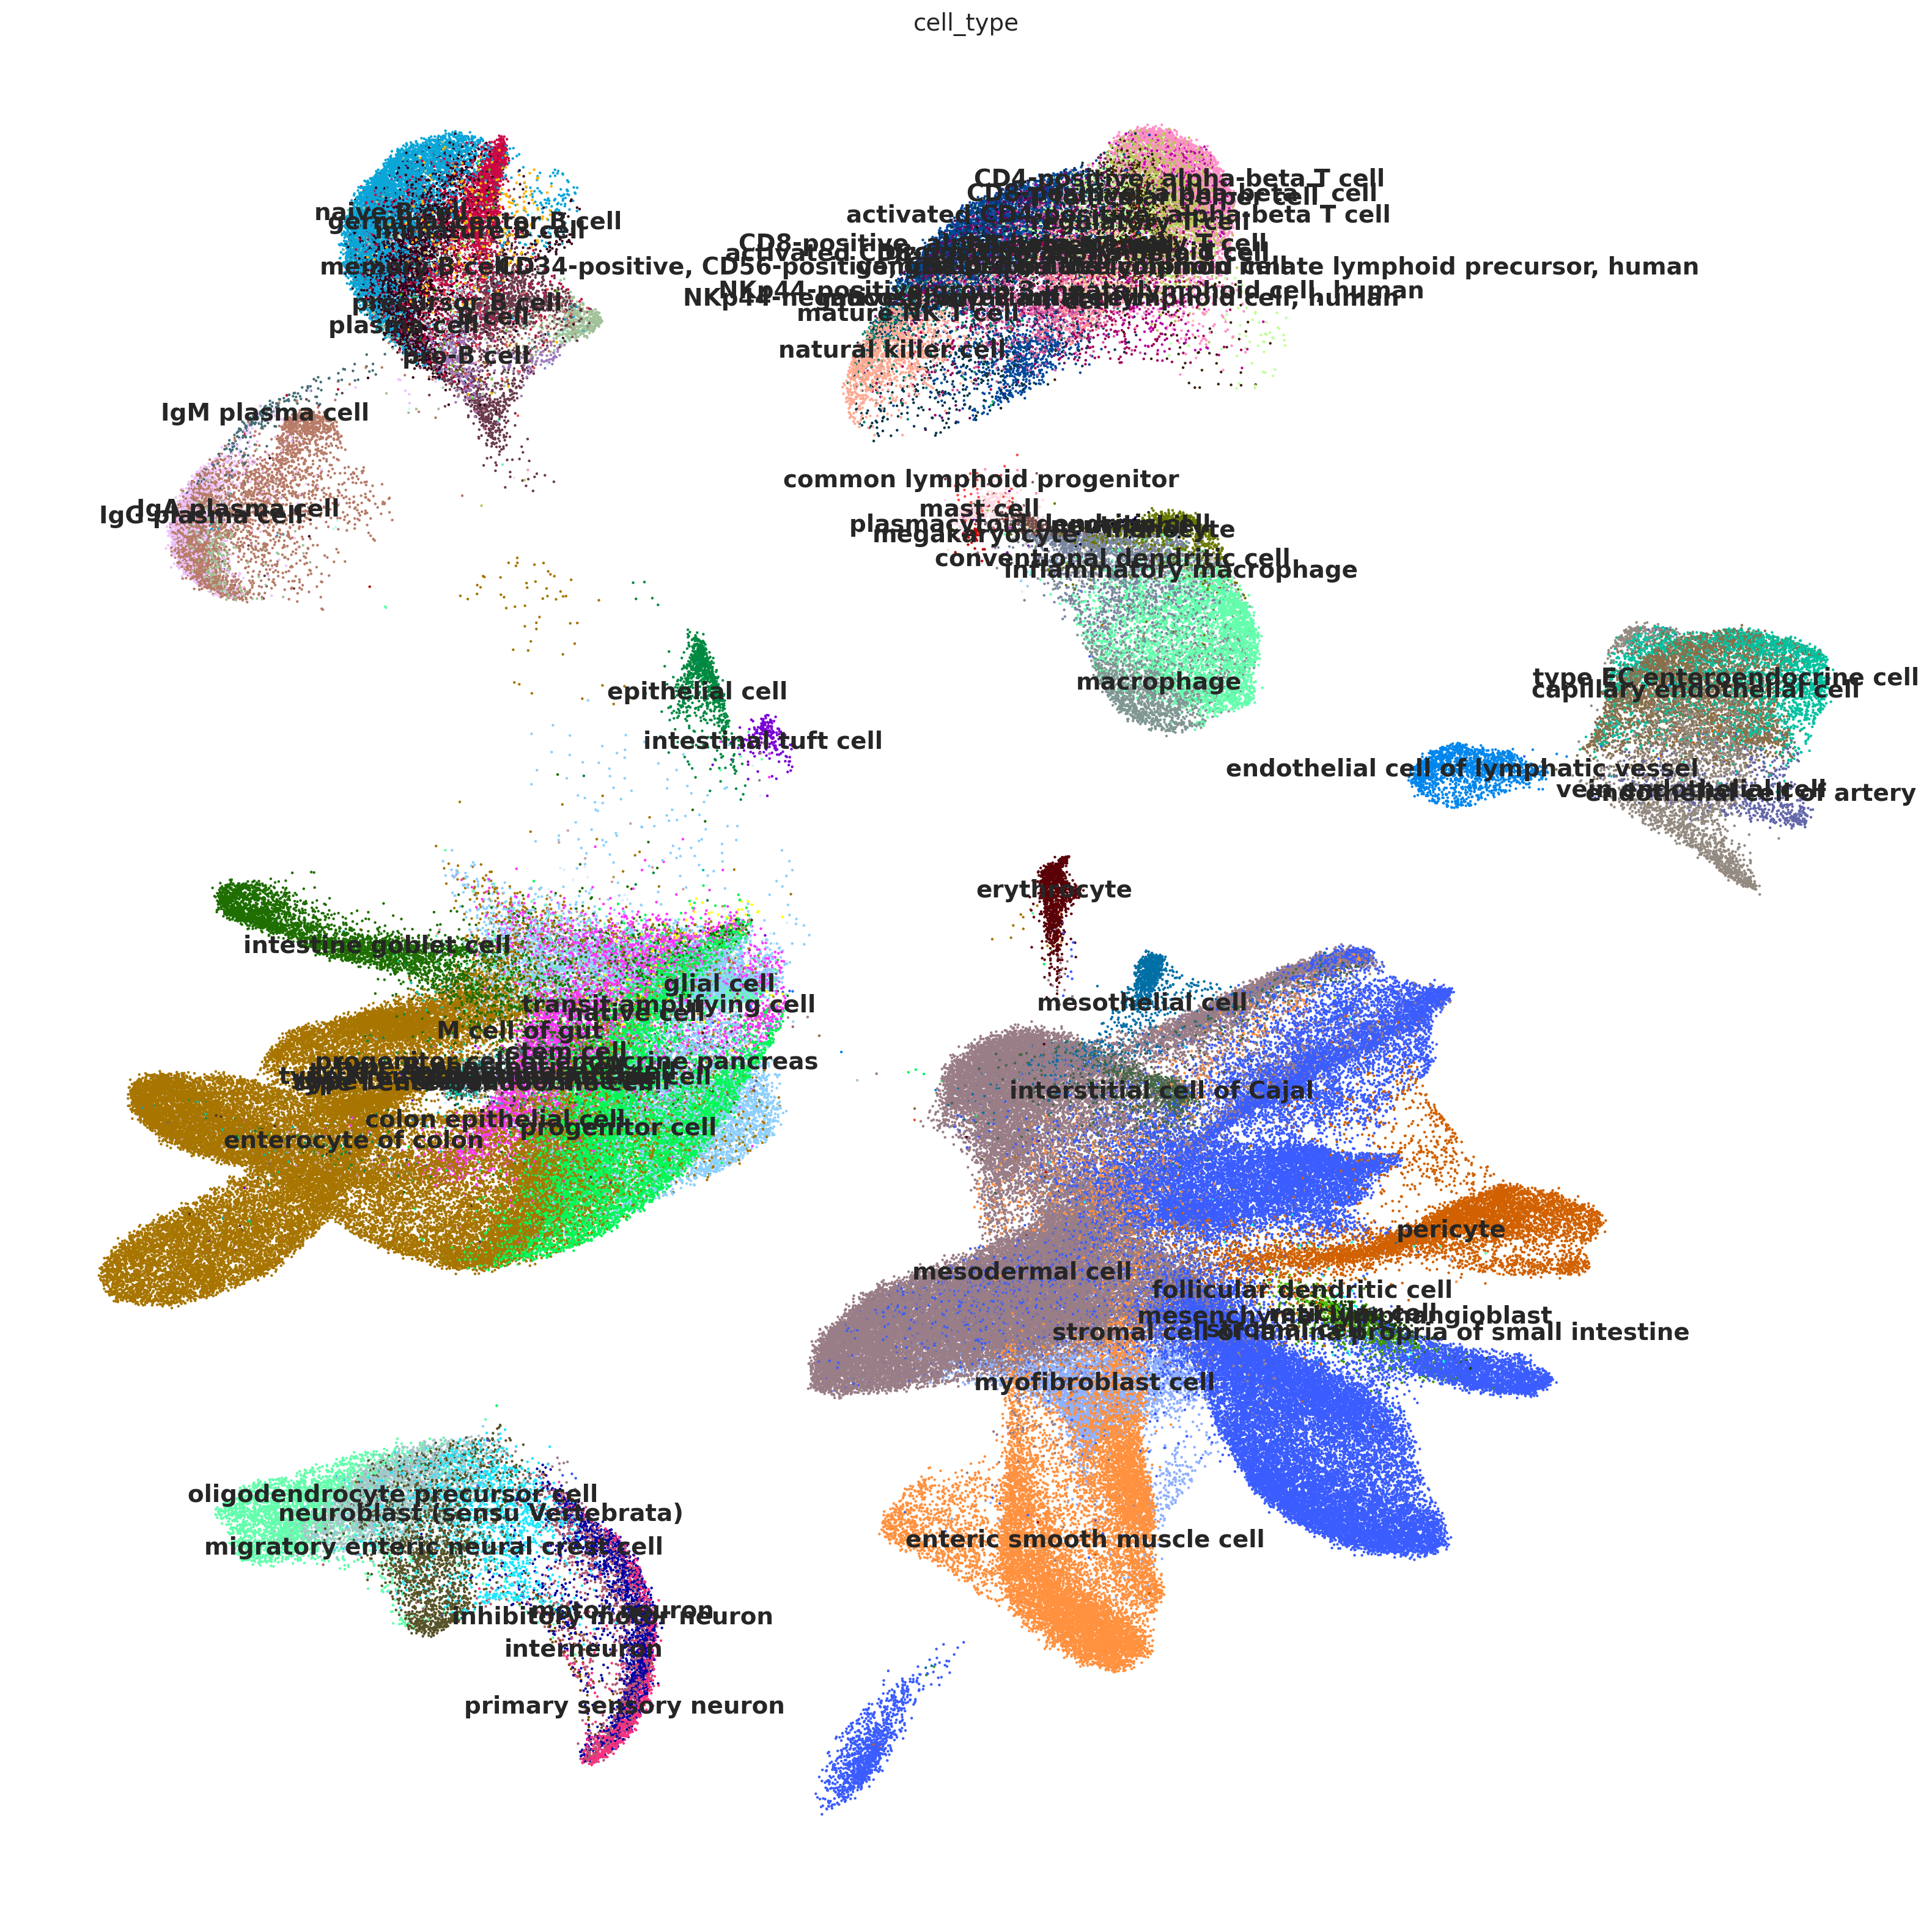

Traceback (most recent call last):
  File "/home/elizabeth/elizabeth/corescpy/corescpy/visualization/spatial_plots.py", line 71, in plot_spatial
    col_segment) else sq.pl.spatial_scatter(ann, **kws)
  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/squidpy/pl/_spatial.py", line 419, in spatial_scatter
    return _spatial_plot(adata, shape=shape, seg=None, seg_key=None, **kwargs)
  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/squidpy/pl/_spatial.py", line 164, in _spatial_plot
    _assert_spatial_basis(adata, spatial_key)
  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/squidpy/gr/_utils.py", line 158, in _assert_spatial_basis
    raise KeyError(f"Spatial basis `{key}` not found in `adata.obsm`.")
KeyError: 'Spatial basis `spatial` not found in `adata.obsm`.'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/hom

{'clusters': <Figure size 2000x2000 with 0 Axes>,
 'scores_training': <Figure size 1200x300 with 4 Axes>,
 'auc': <Figure size 2000x2000 with 0 Axes>,
 'spatial': 'Traceback (most recent call last):\n  File "/home/elizabeth/elizabeth/corescpy/corescpy/visualization/spatial_plots.py", line 71, in plot_spatial\n    col_segment) else sq.pl.spatial_scatter(ann, **kws)\n  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/squidpy/pl/_spatial.py", line 419, in spatial_scatter\n    return _spatial_plot(adata, shape=shape, seg=None, seg_key=None, **kwargs)\n  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/squidpy/pl/_spatial.py", line 164, in _spatial_plot\n    _assert_spatial_basis(adata, spatial_key)\n  File "/home/elizabeth/elizabeth/miniconda3/envs/py-bio/lib/python3.10/site-packages/squidpy/gr/_utils.py", line 158, in _assert_spatial_basis\n    raise KeyError(f"Spatial basis `{key}` not found in `adata.obsm`.")\nKeyErro

<Figure size 2000x2000 with 0 Axes>

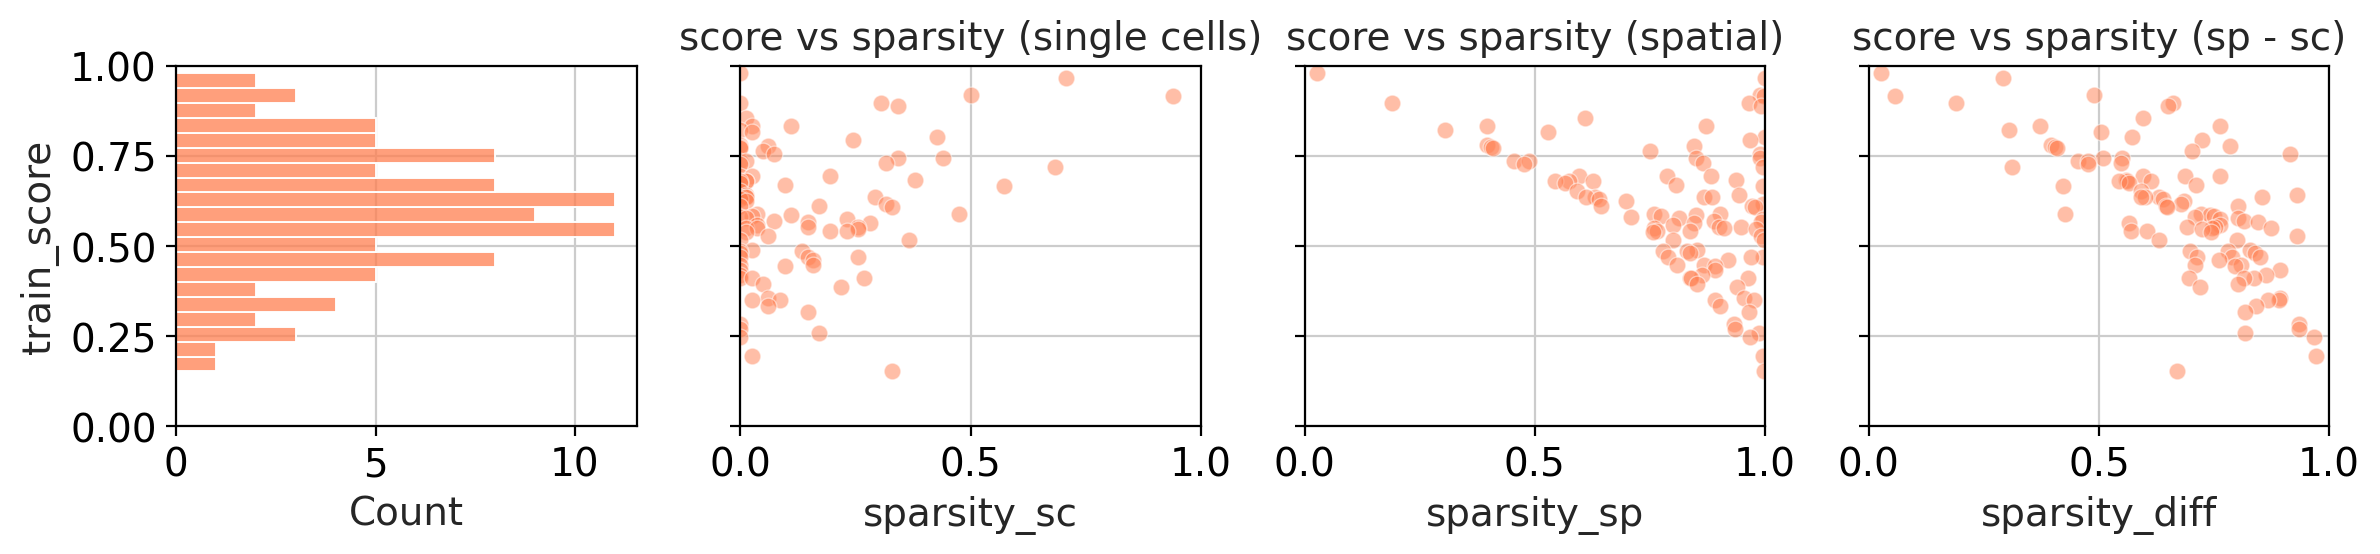

<Figure size 2000x2000 with 0 Axes>

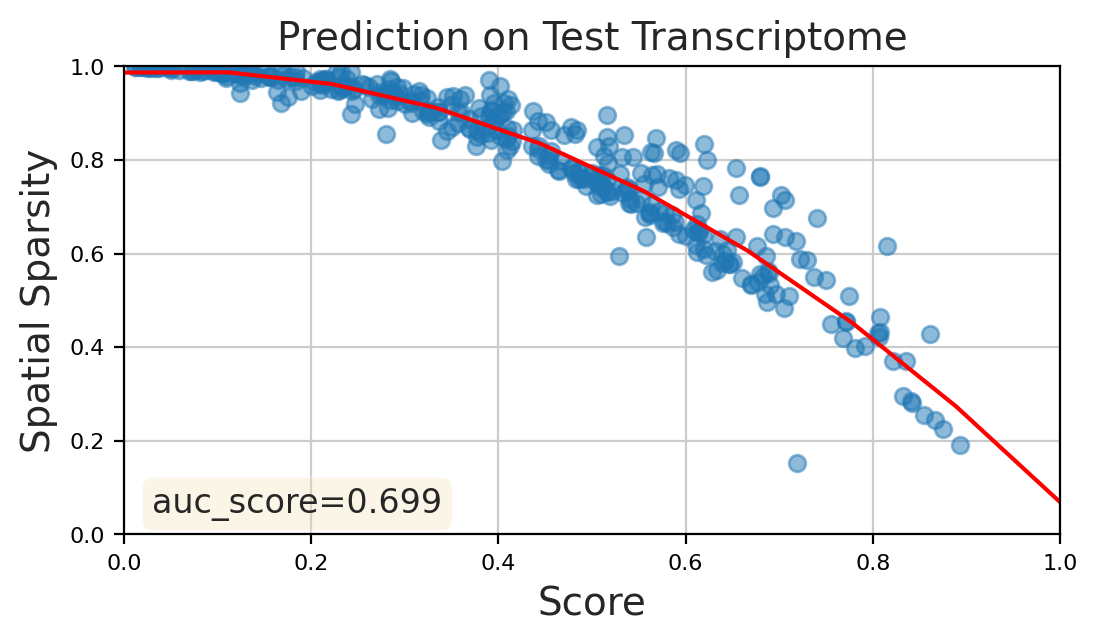

In [42]:
figs = cr.pl.plot_integration_spatial(
    adata_sp, adata_sp_new=adata_sp_new, adata_sc=adata_sc,
    col_cell_type=col_cell_type, ad_map=ad_map, cmap="magma",
    df_compare=df_compare, plot_genes=None, perc=0.01,
    col_annotation=col_annotation)
figs

In [26]:
ad_map

AnnData object with n_obs × n_vars = 82 × 312393
    obs: 'cell_type', 'cluster_density'
    var: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'Sample', 'Sample ID', 'Patient', 'Status', 'Project', 'Sample Location', 'Inflamed', 'Slide', 'GRID ID', 'Procedure Date', 'Age', 'Sex', 'Race', 'Hispanic', 'Diagnosis', 'Project.1', 'Procedure', 'Disease Status', 'Date Collected', 'Date Sectioned', 'Date of Hybridization', 'Storage in 4C', 'Created By', 'Created', 'Storage Status', 'Sample Location.1', 'Storage Row', 'Storage Col', 'Checked Out By', 'Stricture', 'Condition', 'file_path', 'n_counts', 'log_counts', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'assay_protein', 'col_gene_symbols', 'col_cell_type', 'col_sample_id', 'col_batch', 'col_subject', 'col_condition', 'col_num_umis', 'col_segment', 'cell_

In [ ]:
key_cell_type, col_ann = None, "leiden_sub"
for s in selves:
    s.plot_spatial(color=col_ann)

In [ ]:
s.annotate_clusters(file_ann, col_cell_type="leiden", col_annotation="Annotation")
s.annotate_clusters(file_ann, col_cell_type="leiden_subcluster", col_annotation="Annotation_Subcluster")
s.plot_spatial(color="Annotation_Subcluster")

In [ ]:
dff = pd.concat([pd.Series(marker_genes_dict[x]).to_frame("Marker")
                 for x in marker_genes_dict], keys=marker_genes_dict)
dff[dff.Marker.isin(self.rna.var_names)]

In [ ]:
adf = pd.read_excel(file_ann)
adf


i = 0
self = selves[i]
self.add_image(paths_he[i], name="H_E", file_align=paths_he_align[i])